In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras

from keras.utils import np_utils
from keras import utils
from sklearn.model_selection import train_test_split

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt

import pywt
from sklearn.metrics import roc_auc_score, RocCurveDisplay, average_precision_score, PrecisionRecallDisplay, auc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# load data set
df_train = pd.read_csv("/content/drive/MyDrive/MLHC_PROJECT1/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv("/content/drive/MyDrive/MLHC_PROJECT1/mitbih_test.csv", header=None)

y_train = np.array(df_train[187].values).astype(np.int8)
X_train = np.array(df_train[list(range(187))].values)[..., np.newaxis]

y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

In [4]:
# pre-processing for the DBLSTM-WS model
def DWT(signal, levels):
  coeffs = pywt.wavedec(signal.flatten(), 'db6', mode='symmetric', level=levels)[1:]
  coeffs = [np.pad(np.array(c), (0, 187-len(c))) for c in coeffs]
  coeffs += [signal]
  return np.stack(coeffs, axis=-1)

def WSpreprocess(dataset, levels):
  return np.squeeze(np.apply_along_axis(DWT, 1, dataset, levels))

X_train_new = WSpreprocess(np.squeeze(X_train), 2)
X_test_new = WSpreprocess(np.squeeze(X_test), 2)

In [5]:
ensemble_predictions = np.zeros((21892, 5))

path = "/content/drive/MyDrive/MLHC_PROJECT1/H5/MIT/"
import os
for filename in os.listdir(path):
  print(filename)
 
  model = keras.models.load_model(path + filename)

  if filename == "DBLSTM-WS_mit.h5":
     y_pred = model.predict(X_test_new)
  else:
    y_pred = model.predict(X_test)

  ensemble_predictions = ensemble_predictions + y_pred

transformer_mit.h5
CNN_mit.h5
RNN_mit.h5
DBLSTM-WS_mit.h5


In [6]:
y_pred = np.argmax(ensemble_predictions, axis=-1)

f1 = f1_score(y_test, y_pred, average="macro")
print("Test f1 score : %s "% f1)

acc = accuracy_score(y_test, y_pred)
print("Test accuracy score : %s "% acc)

Test f1 score : 0.8865583121096187 
Test accuracy score : 0.9809519459163165 


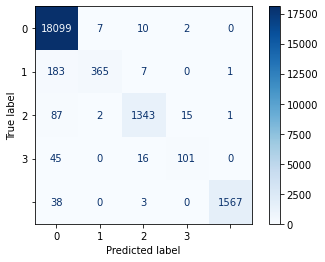

In [7]:
# Plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3])

disp.plot(cmap=plt.cm.Blues)
plt.show()